In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D)

import gymnasium as gym
from gymnasium import spaces

import ray
from ray.rllib.algorithms.ppo import PPOConfig



In [2]:
def positional_encoding_3d(pos, num_freqs=4, max_freq=10.0):
    """
    pos: np.array shape (3,) with (x, y, z) in [-space_size, space_size].
    Returns: encoding vector of shape (3 * 2 * num_freqs,)
    """
    pos = np.asarray(pos, dtype=np.float32)
    assert pos.shape == (3,)

    freqs = np.linspace(1.0, max_freq, num_freqs)
    enc = []
    for coord in pos:            # x, y, z
        for f in freqs:
            enc.append(np.sin(f * coord))
            enc.append(np.cos(f * coord))
    return np.array(enc, dtype=np.float32)


class FrogFly3DEnv(gym.Env):
    """
    3D continuous environment:
    - Frog (agent) moves to catch a moving fly.
    - Observations: positions + relative vector + positional encodings.
    """
    metadata = {"render_modes": ["human"], "render_fps": 30}

    def __init__(self, config=None):
        super().__init__()

        if config is None:
            config = {}

        self.space_size = float(config.get("space_size", 1.0))
        self.step_size = float(config.get("step_size", 0.1))
        self.fly_speed = float(config.get("fly_speed", 0.05))
        self.catch_radius = float(config.get("catch_radius", 0.15))
        self.max_steps = int(config.get("max_steps", 200))
        self.num_freqs = int(config.get("num_freqs", 4))
        self.use_positional_encodings = bool(
            config.get("use_positional_encodings", True)
        )

        # Action = 3D movement in [-1, 1]^3
        self.action_space = spaces.Box(
            low=-1.0, high=1.0, shape=(3,), dtype=np.float32
        )

        # Observation components
        # frog_pos (3) + fly_pos (3) + rel (3) = 9
        base_dim = 9
        if self.use_positional_encodings:
            pe_dim = 3 * 2 * self.num_freqs  # per position
            obs_dim = base_dim + 2 * pe_dim
        else:
            obs_dim = base_dim

        self.observation_space = spaces.Box(
            low=-5.0, high=5.0, shape=(obs_dim,), dtype=np.float32
        )

        self.frog_pos = None
        self.fly_pos = None
        self.steps = 0

    # ---------- Helpers ----------

    def _sample_position(self):
        return np.random.uniform(
            low=-self.space_size,
            high=self.space_size,
            size=(3,),
        ).astype(np.float32)

    def _clip_position(self, pos):
        return np.clip(pos, -self.space_size, self.space_size).astype(np.float32)

    def _get_obs(self):
        rel = self.fly_pos - self.frog_pos
        parts = [self.frog_pos, self.fly_pos, rel]

        if self.use_positional_encodings:
            frog_pe = positional_encoding_3d(self.frog_pos, self.num_freqs)
            fly_pe = positional_encoding_3d(self.fly_pos, self.num_freqs)
            parts.extend([frog_pe, fly_pe])

        return np.concatenate(parts, axis=0).astype(np.float32)

    def _get_distance(self):
        return float(np.linalg.norm(self.fly_pos - self.frog_pos))

    # ---------- Gymnasium API ----------

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.steps = 0
        self.frog_pos = self._sample_position()
        self.fly_pos = self._sample_position()

        obs = self._get_obs()
        info = {}
        return obs, info

    def step(self, action):
        self.steps += 1

        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, -1.0, 1.0)

        # Frog moves
        self.frog_pos = self.frog_pos + self.step_size * action
        self.frog_pos = self._clip_position(self.frog_pos)

        # Fly moves randomly
        fly_dir = np.random.normal(size=(3,)).astype(np.float32)
        fly_dir /= np.linalg.norm(fly_dir) + 1e-8
        self.fly_pos = self.fly_pos + self.fly_speed * fly_dir
        self.fly_pos = self._clip_position(self.fly_pos)

        dist = self._get_distance()
        caught = dist < self.catch_radius

        # Reward shaping: closer is better + bonus for catch
        reward = -dist
        if caught:
            reward += 10.0

        terminated = caught
        truncated = self.steps >= self.max_steps

        obs = self._get_obs()
        info = {"distance": dist, "caught": caught}

        return obs, reward, terminated, truncated, info

    def render(self):
        print(
            f"Step {self.steps} | "
            f"Frog: {self.frog_pos} | Fly: {self.fly_pos} | "
            f"Dist: {self._get_distance():.3f}"
        )

    def close(self):
        pass

In [3]:
import numpy as np
import torch
import torch.nn as nn
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.models import ModelCatalog

ray.shutdown()
ray.init(ignore_reinit_error=True)

class FrogTransformerModel(TorchModelV2, nn.Module):
    def __init__(
        self,
        obs_space,
        action_space,
        num_outputs,
        model_config,
        name,
        **kwargs,  # 👈 swallow extra kwargs RLlib might pass (like d_model)
    ):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        # ---- Observation shape ----
        self.obs_dim = int(np.prod(obs_space.shape))

        # ---- Hyperparameters ----
        cmc = model_config.get("custom_model_config", {}) or {}

        def get_hp(key, default):
            return kwargs.get(key, cmc.get(key, default))

        d_model      = get_hp("d_model", 128)
        nhead        = get_hp("nhead", 4)
        num_layers   = get_hp("num_layers", 2)
        dim_ff       = get_hp("dim_feedforward", 256)
        dropout      = get_hp("dropout", 0.1)

        self.seq_len = self.obs_dim

        # ---- Embedding + Transformer ----
        self.embed = nn.Linear(1, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_ff,
            dropout=dropout,
            batch_first=True,
            activation="relu",
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        # ---- Policy & value heads ----
        self.policy_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, num_outputs),
        )
        self.value_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, 1),
        )

        self._features = None

    def forward(self, input_dict, state, seq_lens):
        x = input_dict["obs"].float()        # (B, obs_dim)
        B = x.shape[0]

        # Treat each scalar as a token: (B, T, 1)
        x = x.view(B, self.seq_len, 1)
        x = self.embed(x)                    # (B, T, d_model)
        x = self.transformer(x)              # (B, T, d_model)

        # Mean-pool tokens
        features = x.mean(dim=1)             # (B, d_model)

        # 🔒 Guard against NaNs/Infs in features
        features = torch.nan_to_num(features, nan=0.0, posinf=1e4, neginf=-1e4)

        self._features = features

        logits = self.policy_head(features)  # (B, num_outputs)

        # 🔒 Guard against NaNs/Infs in logits
        logits = torch.nan_to_num(logits, nan=0.0, posinf=1e4, neginf=-1e4)

        return logits, state

    def value_function(self):
        assert self._features is not None
        v = self.value_head(self._features)
        # 🔒 Guard again, just in case
        v = torch.nan_to_num(v, nan=0.0, posinf=1e4, neginf=-1e4)
        return v.squeeze(-1)


ModelCatalog.register_custom_model("frog_transformer_policy", FrogTransformerModel)



2025-11-29 19:44:47,236	INFO worker.py:2023 -- Started a local Ray instance.
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


In [4]:
from ray.rllib.algorithms.ppo import PPOConfig

env_config = {
    "space_size": 1.0,
    "step_size": 0.1,
    "fly_speed": 0.05,
    "catch_radius": 0.15,
    "max_steps": 200,
    "num_freqs": 4,
    "use_positional_encodings": True,
}

config = (
    PPOConfig()
    .environment(env=FrogFly3DEnv, env_config=env_config)
    .framework("torch")
    .api_stack(
        enable_rl_module_and_learner=False,
        enable_env_runner_and_connector_v2=False,
    )
    .env_runners(
        num_env_runners=1,
        num_envs_per_env_runner=4,
        create_env_on_local_worker=True,
    )
    .resources(num_gpus=0)
    .training(
        model={
            "custom_model": "frog_transformer_policy",
            "custom_model_config": {
                "d_model": 64,          # smaller = safer/faster
                "nhead": 4,
                "num_layers": 1,
                "dim_feedforward": 128,
                "dropout": 0.1,
            },
        },
        gamma=0.99,
        lr=1e-4,           # 🔽 lower LR
        grad_clip=0.5,     # 🔒 global grad norm clip

        train_batch_size=2000,
        num_epochs=10,
        minibatch_size=256,
        clip_param=0.2,
        vf_clip_param=10.0,
    )
)

algo = config.build()
print("✅ Algo built OK with *faster* Transformer PPO config")



2025-11-29 19:44:47,987	WARNING 728841178.py:50 -- DeprecationWarning: `build` has been deprecated. Use `AlgorithmConfig.build_algo` instead. This will raise an error in the future!
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:525: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/opt/anaconda3/envs/rl-project/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.appe

✅ Algo built OK with *faster* Transformer PPO config


In [5]:
res = algo.train()
print(res.keys())
print(res)


2025-11-29 19:44:51,740	WARNING train_ops.py:114 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!


dict_keys(['custom_metrics', 'episode_media', 'info', 'env_runners', 'num_healthy_workers', 'actor_manager_num_outstanding_async_reqs', 'num_remote_worker_restarts', 'num_agent_steps_sampled', 'num_agent_steps_trained', 'num_env_steps_sampled', 'num_env_steps_trained', 'num_env_steps_sampled_this_iter', 'num_env_steps_trained_this_iter', 'num_env_steps_sampled_throughput_per_sec', 'num_env_steps_trained_throughput_per_sec', 'timesteps_total', 'num_env_steps_sampled_lifetime', 'num_agent_steps_sampled_lifetime', 'num_steps_trained_this_iter', 'agent_timesteps_total', 'timers', 'counters', 'done', 'training_iteration', 'trial_id', 'date', 'timestamp', 'time_this_iter_s', 'time_total_s', 'pid', 'hostname', 'node_ip', 'config', 'time_since_restore', 'iterations_since_restore', 'perf'])
{'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.49946922063827515), 'cur_kl_coeff': np.f

In [6]:
for i in range(10):
    result = algo.train()

    er = result["env_runners"]  # shorthand

    reward_mean = er["episode_return_mean"]
    len_mean    = er["episode_len_mean"]

    print(
        f"Iter {i+1}: "
        f"reward_mean={float(reward_mean):.2f}, "
        f"len_mean={float(len_mean):.1f}"
    )




Iter 1: reward_mean=-294.40, len_mean=185.4
Iter 2: reward_mean=-283.53, len_mean=189.8
Iter 3: reward_mean=-295.41, len_mean=192.5


(pid=gcs_server) [2025-11-29 19:45:16,564 E 87267 63478295] (gcs_server) gcs_server.cc:303: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(raylet) [2025-11-29 19:45:17,187 E 87271 63478397] (raylet) main.cc:979: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(RolloutWorker pid=87275) [2025-11-29 19:45:17,872 E 87275 63478689] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
[2025-11-29 19:45:17,991 E 87256 63478447] core_worker_process.cc:837: Failed to establish connection to the metrics exporter agent. Metri

Iter 4: reward_mean=-293.61, len_mean=191.7
Iter 5: reward_mean=-301.06, len_mean=193.3
Iter 6: reward_mean=-294.96, len_mean=189.5
Iter 7: reward_mean=-297.88, len_mean=190.8
Iter 8: reward_mean=-296.90, len_mean=190.9
Iter 9: reward_mean=-295.01, len_mean=191.3
Iter 10: reward_mean=-289.61, len_mean=189.9


In [7]:
def get_train_metrics(result):
    """Extract mean reward and len from an RLlib result dict (env_runners layout)."""
    er = result.get("env_runners", {})
    reward_mean = float(er.get("episode_return_mean", float("nan")))
    len_mean    = float(er.get("episode_len_mean", float("nan")))
    return reward_mean, len_mean


In [8]:
import numpy as np

eval_env = FrogFly3DEnv(env_config)  # reuse your env_config


def evaluate_policy(algo, env, num_episodes=5, render=False):
    """Run the current policy for a few episodes and return summary stats."""
    returns = []
    lengths = []

    for _ in range(num_episodes):
        obs, info = env.reset()
        done = False
        ep_ret = 0.0
        steps = 0

        while not done:
            action = algo.compute_single_action(obs, explore=False)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            ep_ret += reward
            steps += 1

            if render:
                env.render()

        returns.append(ep_ret)
        lengths.append(steps)

    return {
        "mean_return": float(np.mean(returns)),
        "std_return": float(np.std(returns)),
        "mean_length": float(np.mean(lengths)),
    }


In [9]:
import os

num_iterations = 200        # 🔁 how long you want to train
eval_interval  = 10         # 📈 how often to run eval
eval_episodes  = 5

train_history = []          # for plotting later
best_eval_return = -float("inf")
checkpoint_dir = "frog_transformer_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

for i in range(1, num_iterations + 1):
    # ---- 1. One PPO training iteration ----
    result = algo.train()
    train_reward, train_len = get_train_metrics(result)

    # ---- 2. Periodic evaluation ----
    if i % eval_interval == 0:
        eval_stats = evaluate_policy(algo, eval_env, num_episodes=eval_episodes, render=False)
        eval_return = eval_stats["mean_return"]
        eval_len    = eval_stats["mean_length"]

        # Log nicely
        print(
            f"[Iter {i:4d}] "
            f"train_reward={train_reward:8.2f}, "
            f"train_len={train_len:6.1f}, "
            f"eval_return={eval_return:8.2f} ± {eval_stats['std_return']:6.2f}, "
            f"eval_len={eval_len:6.1f}"
        )

        # Save history
        train_history.append(
            {
                "iter": i,
                "train_reward": train_reward,
                "train_len": train_len,
                "eval_return": eval_return,
                "eval_len": eval_len,
            }
        )

        # ---- 3. Optional: save best checkpoint ----
        if eval_return > best_eval_return:
            best_eval_return = eval_return
            checkpoint_path = algo.save(checkpoint_dir)
            print(f"  ✅ New best eval_return={best_eval_return:.2f}, saved to {checkpoint_path}")
    else:
        # Lighter log on non-eval iterations
        print(
            f"[Iter {i:4d}] "
            f"train_reward={train_reward:8.2f}, "
            f"train_len={train_len:6.1f}"
        )


[Iter    1] train_reward= -284.55, train_len= 189.9
[Iter    2] train_reward= -281.69, train_len= 189.9
[Iter    3] train_reward= -284.21, train_len= 191.0
[Iter    4] train_reward= -282.73, train_len= 189.1
[Iter    5] train_reward= -281.21, train_len= 190.8
[Iter    6] train_reward= -284.46, train_len= 192.5
[Iter    7] train_reward= -285.91, train_len= 193.3
[Iter    8] train_reward= -286.58, train_len= 192.3
[Iter    9] train_reward= -290.79, train_len= 191.1


2025-11-29 19:46:56,126	WARNING 1069323533.py:18 -- DeprecationWarning: `compute_single_action` has been deprecated. `Algorithm.compute_single_action` should no longer be used. Get the RLModule instance through `Algorithm.get_module([module ID])`, then compute actions through `RLModule.forward_inference({'obs': [obs batch]})`. This will raise an error in the future!


[Iter   10] train_reward= -299.38, train_len= 195.7, eval_return= -263.32 ±  75.20, eval_len= 200.0
  ✅ New best eval_return=-263.32, saved to TrainingResult(checkpoint=Checkpoint(filesystem=local, path=frog_transformer_checkpoints), metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float64(0.5), 'cur_kl_coeff': np.float64(1.8310546875000006e-05), 'cur_lr': np.float64(0.00010000000000000005), 'total_loss': np.float64(9.696848460606166), 'policy_loss': np.float64(-0.006743850878306798), 'vf_loss': np.float64(9.703592232295446), 'vf_explained_var': np.float64(0.00020001275198800223), 'kl': np.float64(0.003994126659901147), 'entropy': np.float64(3.438131822858538), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(256.0), 'num_grad_updates_lifetime': np.float64(1435.5), 'diff_num_grad_updates_vs_sampler_policy': np.flo

KeyboardInterrupt: 

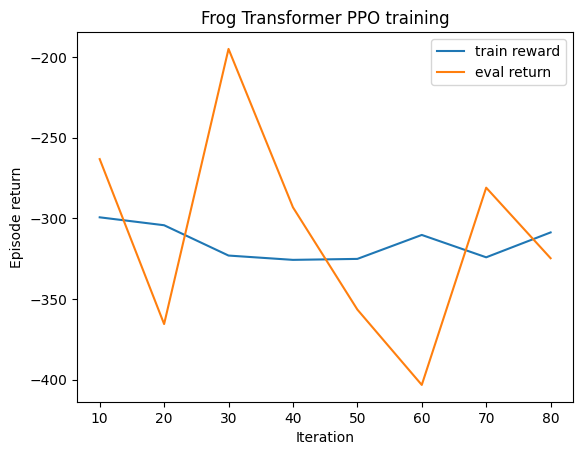

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df_hist = pd.DataFrame(train_history)

plt.figure()
plt.plot(df_hist["iter"], df_hist["train_reward"], label="train reward")
plt.plot(df_hist["iter"], df_hist["eval_return"], label="eval return")
plt.xlabel("Iteration")
plt.ylabel("Episode return")
plt.legend()
plt.title("Frog Transformer PPO training")
plt.show()
